In [1]:
from scipy.spatial.distance import pdist
#from scipy.ndimage import uniform_filter
from collections import Counter
from zensvi.cv import Segmenter
from scipy.stats import entropy
from tqdm.notebook import tqdm
from skimage import measure
from PIL import Image
from zensvi.cv import DepthEstimator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <BFAC0362-079C-3D60-A731-79532A75BA60> /Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mquintana/miniforge3/envs/greenery/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can igno

Weights file already exists.


/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Utility functions

In [ ]:
def process_segmentation(image_path, tolerance=3):
    # read image
    img = cv2.imread(image_path)

    # check if image was loaded successfully
    if img is None:
        raise ValueError(f"Failed to load image at path: {image_path}")
    
    # OpenCV loads in BGR, convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # greenery colors based on Mapillary Vistas
    vegetation_color = np.array([107, 142, 35])  # Olive green
    terrain_color = np.array([153, 250, 152])    # Light green)

    # create masks for each color with tolerance
    def create_color_mask(image, color, tolerance=3):
        # Create lower and upper bounds
        lower_bound = np.clip(color - tolerance, 0, 255)
        upper_bound = np.clip(color + tolerance, 0, 255)
        
        # Create mask using cv2.inRange
        mask = cv2.inRange(image, lower_bound, upper_bound)
        return mask

    # create individual masks
    vegetation_mask = create_color_mask(img, vegetation_color, tolerance)
    terrain_mask = create_color_mask(img, terrain_color, tolerance)

    # combine masks
    combined_mask = cv2.bitwise_or(vegetation_mask, terrain_mask)

    # compute GVI
    total_pixels = img.shape[0] * img.shape[1]
    green_pixels = np.count_nonzero(combined_mask)
    gvi = green_pixels / total_pixels

    return combined_mask, gvi

In [ ]:
def process_segmentation_figure(image_path, tolerance=3):
    # read image
    img = cv2.imread(image_path)

    # check if image was loaded successfully
    if img is None:
        raise ValueError(f"Failed to load image at path: {image_path}")
    
    # OpenCV loads in BGR, convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # greenery colors based on figure sketch
    vegetation_color_1 = np.array([8, 112, 10]) 
    vegetation_color_2 = np.array([52, 144, 23]) 
    vegetation_color_3 = np.array([116, 201, 36]) 

    # create masks for each color with tolerance
    def create_color_mask(image, color, tolerance=3):
        # Create lower and upper bounds
        lower_bound = np.clip(color - tolerance, 0, 255)
        upper_bound = np.clip(color + tolerance, 0, 255)
        
        # Create mask using cv2.inRange
        mask = cv2.inRange(image, lower_bound, upper_bound)
        return mask

    # create individual masks
    vegetation_mask_1 = create_color_mask(img, vegetation_color_1, tolerance)
    vegetation_mask_2= create_color_mask(img, vegetation_color_2, tolerance)
    vegetation_mask_3 = create_color_mask(img, vegetation_color_3, tolerance)

    # combine masks
    combined_mask = cv2.bitwise_or(vegetation_mask_1, vegetation_mask_2)
    combined_mask = cv2.bitwise_or(combined_mask, vegetation_mask_3)

    # compute GVI
    total_pixels = img.shape[0] * img.shape[1]
    green_pixels = np.count_nonzero(combined_mask)
    gvi = green_pixels / total_pixels

    return combined_mask, gvi

In [22]:
def spatial_entropy_2d_relative_optimized(mask, relative_window_size=0.25):
    """
    Calculate local entropy across the image using relative window sizes.
    GPU-accelerated implementation optimized for Apple Silicon (M2).
    
    Parameters:
    -----------
    mask : numpy.ndarray
        Binary mask image (2D array)
    relative_window_size : float
        Window size as a fraction of the smaller image dimension (default: 0.25)
        
    Returns:
    --------
    float
        Average spatial entropy across the image
    """
    # Ensure mask is binary (0s and 1s)
    mask = (mask > 0).astype(np.float32)

    # avoid log(0)
    epsilon = 1e-7
  
    sigma_factor = 0.25

    # Get image dimensions
    height, width = mask.shape
    
    # Calculate window size and make it odd for easier handling
    window_size = max(4, int(min(height, width) * relative_window_size))
    window_size = window_size if window_size % 2 == 1 else window_size + 1

    # For normal cases:
    kernel = np.ones((window_size, window_size), dtype=np.float32)
    
    # Compute sum of pixels in each window
    sum_windows = cv2.filter2D(mask, -1, kernel, borderType=cv2.BORDER_CONSTANT)
    # Crop the result to match the 'valid' mode from the original function
    sum_windows = sum_windows[window_size-1:height, window_size-1:width] 

    # Calculate probabilities
    window_area = window_size * window_size
    p = sum_windows / window_area
    
    # Create entropy map
    entropy_map = np.zeros_like(p)
    
    # Calculate entropy only for valid probabilities
    valid_indices = np.logical_and(p > epsilon, p < (1.0 - epsilon))
    
    if np.any(valid_indices):
        p_valid = p[valid_indices]
        entropy_valid = -p_valid * np.log2(p_valid) - (1.0 - p_valid) * np.log2(1.0 - p_valid)
        entropy_map[valid_indices] = entropy_valid
        return np.mean(entropy_map)
    else:
        return 0.0

In [8]:
def get_window_sizes(mask, list_windows, relative_window_size=0.25):
    """
    """
    # Ensure mask is float32 for better precision with OpenCV
    mask = mask.astype(np.float32)
    
    # Get image dimensions
    height, width = mask.shape
    
    # Calculate window size as a fraction of the smaller dimension
    window_size = int(min(height, width) * relative_window_size)
    
    # Ensure window size is at least 4 pixels
    window_size = max(4, window_size)

    list_windows.append(window_size)

    # Return average entropy
    return list_windows

# Entroy analysis: relative window size 

In [12]:
data_folder = "data/segmented_panoptic/"
all_files = os.listdir(data_folder)
segmented_string = "_colored_segmented.png"
segmented_files = [f for f in all_files if segmented_string in f]

entropy_metrics_relative_df = pd.DataFrame(
    columns=[
        "uuid",
        "spatial_010",
        "spatial_015",
        "spatial_020",
        "spatial_025",
        "spatial_030",
        "spatial_035",
        "spatial_040",
        "spatial_045",
        "spatial_050",
        "spatial_055",
        "spatial_060",
        "spatial_065",
        "spatial_070",
        "spatial_075",
        "spatial_080",
        "spatial_085",
        "spatial_090",
        "spatial_095",
        "spatial_100",
    ]
)

# takes some time to run on CPU
for file_name in tqdm(segmented_files, desc="Processing images"):
    # compute mask
    mask, gvi = process_segmentation(data_folder + file_name)

    # compute entropy metrics
    spatial_010 = spatial_entropy_2d_relative_optimized(mask, 0.10)
    spatial_015 = spatial_entropy_2d_relative_optimized(mask, 0.15)
    spatial_020 = spatial_entropy_2d_relative_optimized(mask, 0.20)
    spatial_025 = spatial_entropy_2d_relative_optimized(mask, 0.25)
    spatial_030 = spatial_entropy_2d_relative_optimized(mask, 0.30)
    spatial_035 = spatial_entropy_2d_relative_optimized(mask, 0.35)
    spatial_040 = spatial_entropy_2d_relative_optimized(mask, 0.40)
    spatial_045 = spatial_entropy_2d_relative_optimized(mask, 0.45)
    spatial_050 = spatial_entropy_2d_relative_optimized(mask, 0.50)
    spatial_055 = spatial_entropy_2d_relative_optimized(mask, 0.55)
    spatial_060 = spatial_entropy_2d_relative_optimized(mask, 0.60)
    spatial_065 = spatial_entropy_2d_relative_optimized(mask, 0.65)
    spatial_070 = spatial_entropy_2d_relative_optimized(mask, 0.70)
    spatial_075 = spatial_entropy_2d_relative_optimized(mask, 0.75)
    spatial_080 = spatial_entropy_2d_relative_optimized(mask, 0.80)
    spatial_085 = spatial_entropy_2d_relative_optimized(mask, 0.85)
    spatial_090 = spatial_entropy_2d_relative_optimized(mask, 0.90)
    spatial_095 = spatial_entropy_2d_relative_optimized(mask, 0.95)
    spatial_100 = spatial_entropy_2d_relative_optimized(mask, 1.00)

    # format to a dataframe row
    row = [
        file_name.replace(segmented_string, ""),  # remove substring from name
        # raw metrics
        spatial_010,
        spatial_015,
        spatial_020,
        spatial_025,
        spatial_030,
        spatial_035,
        spatial_040,
        spatial_045,
        spatial_050,
        spatial_055,
        spatial_060,
        spatial_065,
        spatial_070,
        spatial_075,
        spatial_080,
        spatial_085,
        spatial_090,
        spatial_095,
        spatial_100,
    ]
    # update dataframe
    entropy_metrics_relative_df.loc[len(entropy_metrics_relative_df)] = row

    # end for loop

entropy_metrics_relative_df.to_csv("data/labels/processed/spatial_entropy_relative_metrics.csv", index=False)
entropy_metrics_relative_df

Processing images:   0%|          | 0/436 [00:00<?, ?it/s]

,uuid,spatial_010,spatial_015,spatial_020,spatial_025,spatial_030,spatial_035,spatial_040,spatial_045,spatial_050,spatial_055,spatial_060,spatial_065,spatial_070,spatial_075,spatial_080,spatial_085,spatial_090,spatial_095,spatial_100
0,8f227932-e7c9-480c-8bd6-4843b689bd4b,0.198801,0.256865,0.297039,0.324336,0.343174,0.358669,0.361848,0.347523,0.324562,0.297411,0.268010,0.237781,0.208194,0.179234,0.152362,0.128234,0.107948,0.091708,0.0
1,937e89f7-51a9-4ff9-95af-63ce16a523b9,0.238595,0.311153,0.379544,0.436576,0.475379,0.508009,0.536147,0.548911,0.550301,0.544033,0.534117,0.521726,0.509174,0.497338,0.487468,0.479130,0.470513,0.457406,0.0
2,cf55f412-6375-4e27-86f2-2f3789a09a5f,0.243532,0.350548,0.452235,0.558297,0.663406,0.748684,0.802374,0.835230,0.857948,0.870614,0.870458,0.859938,0.842294,0.817897,0.789257,0.757023,0.719917,0.682325,0.0
3,a983c78b-0b5e-463c-aea8-9db29d64af05,0.157523,0.212199,0.257769,0.294817,0.318943,0.315626,0.292253,0.265508,0.236436,0.207637,0.177312,0.148679,0.122010,0.097231,0.075891,0.059571,0.047823,0.040485,0.0
4,d8044123-3bdc-48b4-8fad-00489e4d3bed,0.150931,0.205406,0.250073,0.287548,0.313201,0.328195,0.332589,0.326936,0.321160,0.315375,0.306885,0.297424,0.285285,0.268189,0.251602,0.233895,0.216631,0.202303,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,c15e0899-f6bd-4257-81ae-0a66de564a44,0.170035,0.216192,0.242703,0.237185,0.212689,0.183116,0.153914,0.128225,0.105812,0.085768,0.066622,0.048937,0.034387,0.022364,0.012527,0.005233,0.001179,0.000277,0.0
432,e708d69a-96b9-4bd6-a5b8-e307b4a515bf,0.284643,0.373817,0.447743,0.506288,0.552144,0.590249,0.604831,0.594678,0.571234,0.542430,0.508196,0.470511,0.431495,0.393755,0.359558,0.325418,0.295458,0.271719,0.0
433,02bbf8e5-b3c5-48fa-9642-783b0a5f3c36,0.059160,0.080516,0.100871,0.117543,0.124133,0.118860,0.107509,0.094205,0.082436,0.071051,0.059773,0.048926,0.038886,0.030423,0.023236,0.016390,0.009119,0.003232,0.0
434,6b8cf393-4a17-46ee-ba10-f4274360ca27,0.313668,0.420549,0.494854,0.551344,0.595880,0.625738,0.646517,0.656001,0.652338,0.637984,0.615897,0.590411,0.563364,0.535815,0.510209,0.485238,0.461857,0.437054,0.0


# Shannon entropy calculation

In [13]:
def calculate_segmentation_entropy(segmented_image):
    """
    Calculate entropy based on all colored segments in the image.
    Each unique RGB color combination represents a different segment class.
    
    Args:
        segmented_image: Already segmented image (from cv2.imread)
        
    Returns:
        float: Shannon entropy value
    """
    # Treat each unique RGB combination as a separate segment class
    # Reshape from (height, width, 3) to (height*width, 3)
    img_reshaped = segmented_image.reshape(-1, 3)
    
    # Convert each RGB pixel to a tuple for counting unique colors
    unique_colors = [tuple(pixel) for pixel in img_reshaped]
    
    # Count occurrences of each unique color
    color_counts = Counter(unique_colors)
    
    # Get counts for entropy calculation
    counts = np.array(list(color_counts.values()))
    total_pixels = len(unique_colors) 
        
    # Calculate probabilities for each segment class
    probabilities = counts / total_pixels
    
    # Calculate Shannon entropy: H = -sum(p * log2(p))
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    
    return entropy

In [14]:
data_folder = "data/segmented_panoptic/"
all_files = os.listdir(data_folder)
segmented_string = "_colored_segmented.png"
segmented_files = [f for f in all_files if segmented_string in f]

entropy_metrics_df = pd.DataFrame(
    columns=[
        "uuid",
        "entropy",
    ]
)

# takes some time to run on CPU
for file_name in tqdm(segmented_files, desc="Processing images"):
    img = cv2.imread(data_folder + file_name)
    # compute entropy 
    entropy = calculate_segmentation_entropy(img)
    # format to a dataframe row
    row = [
        file_name.replace(segmented_string, ""),  # remove substring from name
        entropy,
    ]
    # update dataframe
    entropy_metrics_df.loc[len(entropy_metrics_df)] = row

    # end for loop

entropy_metrics_df.to_csv("data/labels/processed/shannon_entropy_metrics.csv", index=False)
entropy_metrics_df

Processing images:   0%|          | 0/436 [00:00<?, ?it/s]

,uuid,entropy
0,8f227932-e7c9-480c-8bd6-4843b689bd4b,2.547417
1,937e89f7-51a9-4ff9-95af-63ce16a523b9,2.465721
2,cf55f412-6375-4e27-86f2-2f3789a09a5f,2.354388
3,a983c78b-0b5e-463c-aea8-9db29d64af05,2.333510
4,d8044123-3bdc-48b4-8fad-00489e4d3bed,2.658109
...,...,...
431,c15e0899-f6bd-4257-81ae-0a66de564a44,2.761412
432,e708d69a-96b9-4bd6-a5b8-e307b4a515bf,2.483054
433,02bbf8e5-b3c5-48fa-9642-783b0a5f3c36,2.643510
434,6b8cf393-4a17-46ee-ba10-f4274360ca27,2.326017


# Figure calculations

In [26]:
# compute masks
mask1, img1_gvi = process_segmentation_figure("img/ChatGPT_1.png", 50)
mask2, img2_gvi = process_segmentation_figure("img/ChatGPT_2.png", 50)
# compute spatial entropy
spatial_045_1 = spatial_entropy_2d_relative_optimized(mask1, 0.45)
spatial_045_2 = spatial_entropy_2d_relative_optimized(mask2, 0.45)
 

In [27]:
spatial_045_1

np.float32(0.46679085)

In [28]:
spatial_045_2

np.float32(0.8450952)

In [8]:
# depth maps
depth_estimator = DepthEstimator(
    device="mps",  # device to use (either "cpu", "cuda", or "mps")
    task="relative", # task to perform (either "relative" or "absolute")
    encoder="vits", # encoder variant ("vits", "vitb", "vitl", "vitg")
    max_depth=100.0 # maximum depth for absolute estimation (only used when task="absolute")
)

dir_input = "img/ChatGPT_1.png"
dir_image_output = "img/" # estimated depth map
depth_estimator.estimate_depth(
    dir_input,
    dir_image_output
)
dir_input = "img/ChatGPT_2.png"
dir_image_output = "img/" # estimated depth map
depth_estimator.estimate_depth(
    dir_input,
    dir_image_output
)
dir_input = "img/ChatGPT_1_and_2_colored.png"
dir_image_output = "img/" # estimated depth map
depth_estimator.estimate_depth(
    dir_input,
    dir_image_output
)

Using mps


Estimating depth: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


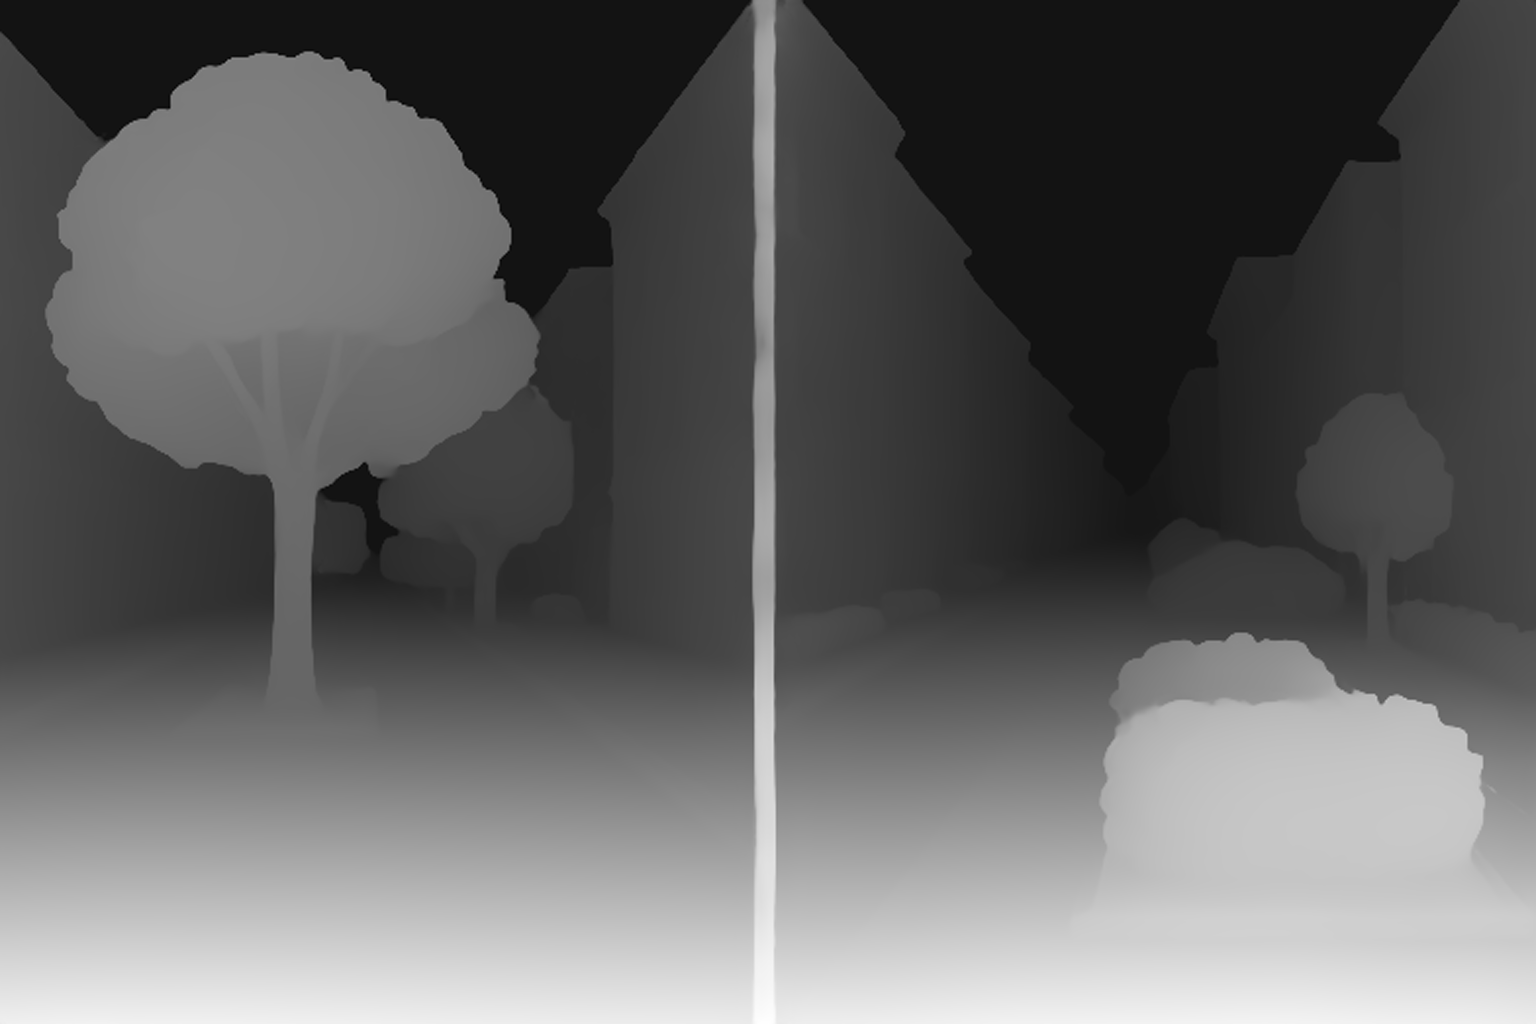

In [5]:
from transformers import pipeline
from PIL import Image

pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
image = Image.open('img/ChatGPT_1_and_2_colored.png')
depth = pipe(image)["depth"]
depth